In this notebook I use astronomical images to train neural network. I start with the case of stars versus galaxies. That should be relatively simple, at least with sufficient signal to noise. 

In [2]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#wcs is incompabible with newest numpy thus below not used 
#from astropy import wcs
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression


Now loading the data on the classification and other properties of the objects to be classified. 

In [4]:
df=pd.read_csv('Stripe82_1.csv',sep=',')
print(df.columns)

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'subclass', 'redshift', 'plate', 'mjd',
       'fiberid'],
      dtype='object')


Now looking on the classes, the targets and their counts. 

In [5]:
print(df['class'].value_counts())

GALAXY    3205
STAR      1735
QSO        355
Name: class, dtype: int64


Making a color (a difference of two magntudes) magnitude diagram. Thiskind of data (there are in total 5 magnitudes) could also be used for classification. 
For now it is ignore since the aim is to use images first. 

(26.0, 12.0)

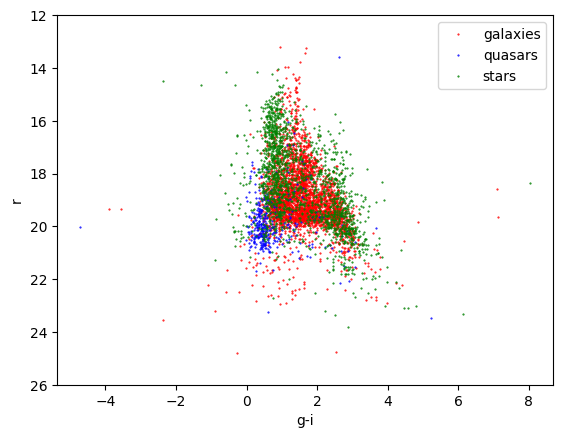

In [6]:
plt.plot(df['g'][df['class']=='GALAXY']-df['i'][df['class']=='GALAXY'],df['r'][df['class']=='GALAXY'],'o',ms=0.5,color='red',label='galaxies') 
plt.plot(df['g'][df['class']=='QSO']-df['i'][df['class']=='QSO'],df['r'][df['class']=='QSO'],'o',ms=0.5,color='blue',label='quasars')
plt.plot(df['g'][df['class']=='STAR']-df['i'][df['class']=='STAR'],df['r'][df['class']=='STAR'],'o',ms=0.5,color='green',label='stars')
plt.legend(loc="best")
plt.xlabel("g-i")
plt.ylabel("r")
plt.ylim(26,12)
#plt.yscale("log")


Now I load an image and to do a first test display of the numeric data.

In [7]:
path='/home/tobias/ml-testing/astr-images/'
hbin=fits.open(path+'f2001_rdeep.fits.gz')
im1=hbin[0].data
#hbin.close()
print(im1)

[[-0.1769429   0.8691173   0.8408659  ... -1.000337   -0.7853276
  -0.45219374]
 [ 0.75963277 -0.4932522   1.3954576  ... -0.41785482 -1.3604484
  -0.5760638 ]
 [ 0.74020797  0.50546163  0.67057353 ...  0.37528276 -0.6279215
  -0.12317654]
 ...
 [ 0.8284947   0.14578946 -0.6937766  ...  1.4887718   2.2809432
   2.2037222 ]
 [ 0.9416072   0.7137203   0.43595394 ...  1.1946634   2.0303423
   2.3305871 ]
 [ 0.57620764 -0.2957804   0.5933519  ...  0.98817205  1.3469133
   2.5567775 ]]


I now built a function which gets the area mcovers by an image. That is used later to find the right image for the targets.

In [14]:
def image_area(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    image=dat[0].data
    res=np.array([[ra_ref+(1-ra_center)*ra_scale,ra_ref+(image.shape[0]-ra_center)*ra_scale],[dec_ref+(1-dec_center)*dec_scale,dec_ref+(image.shape[1]-dec_center)*dec_scale]])
    return res

Similiarly the function image_par gets the coordinate parameter of an image for this data set.

In [16]:
#assumes that the image pixel coordiantes are perfectly aligned with the skyb coordiates ra and dec
#that is true for this data set but in general another two parameters are needed to specify the miss alignment
def image_par(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    par=np.array([ra_ref,ra_center,ra_scale,dec_ref,dec_center,dec_scale])
    return par

Below I test the image area function.

In [18]:
res=image_area(hbin)
print(res)

[[50.00036 49.49964]
 [-1.25036 -0.74964]]


Below I build a function which gets the image position of an object whose sky position is known. 
The information on the image can be either obtained from an image or from the opreviously collected image coordinate parameters.

In [19]:
#ra dec position coordinate of object, dat is image inpt, not zero if image==True,
# par is parameter inpu not yero if image==False
def image_xy(ra,dec,dat=0,par=0,image=True):
    #image is used input and the parameters are used
    if image==True:
        ra_ref=dat[0].header['CRVAL1']
        ra_center=dat[0].header['CRPIX1']
        ra_scale=dat[0].header['CD1_1']
        dec_ref=dat[0].header['CRVAL2']
        dec_center=dat[0].header['CRPIX2']
        dec_scale=dat[0].header['CD2_2'] 
    #paramter input    
    else:   
        ra_ref=par[0]
        ra_center=par[1]
        ra_scale=par[2]
        dec_ref=par[3]
        dec_center=par[4]
        dec_scale=par[5]
    #get the positions (pixels on image) 
    # the cosine part is only important if the image not close to the euqator 
    x=ra_center+(ra-ra_ref)/ra_scale*np.cos(dec/180*np.pi)
    y=dec_center+(dec-dec_ref)/dec_scale
    pixels=np.array([x,y])
    return pixels

Test use on image.

In [20]:
pixels=image_xy(49.8,-1,dat=hbin,image=True)
print(f"pixels are {pixels}")

pixels are [1822.52377493 2277.        ]


Now getting all images in a list. 

In [21]:
list_input_files=[f for f in os.listdir(path) 
    if f.endswith('_rdeep.fits.gz') and os.path.isfile(os.path.join(path, f))]
list_input_files.sort()
print(list_input_files)

['f2001_rdeep.fits.gz', 'f2002_rdeep.fits.gz', 'f2003_rdeep.fits.gz', 'f2004_rdeep.fits.gz', 'f2005_rdeep.fits.gz', 'f2011_rdeep.fits.gz', 'f2012_rdeep.fits.gz', 'f2013_rdeep.fits.gz', 'f2014_rdeep.fits.gz', 'f2015_rdeep.fits.gz', 'f2021_rdeep.fits.gz', 'f2022_rdeep.fits.gz', 'f2023_rdeep.fits.gz', 'f2024_rdeep.fits.gz', 'f2025_rdeep.fits.gz', 'f2031_rdeep.fits.gz', 'f2032_rdeep.fits.gz', 'f2033_rdeep.fits.gz', 'f2034_rdeep.fits.gz', 'f2035_rdeep.fits.gz', 'f2041_rdeep.fits.gz', 'f2042_rdeep.fits.gz', 'f2043_rdeep.fits.gz', 'f2044_rdeep.fits.gz', 'f2045_rdeep.fits.gz', 'f2051_rdeep.fits.gz', 'f2052_rdeep.fits.gz', 'f2053_rdeep.fits.gz', 'f2054_rdeep.fits.gz', 'f2055_rdeep.fits.gz', 'f2061_rdeep.fits.gz', 'f2062_rdeep.fits.gz', 'f2063_rdeep.fits.gz', 'f2064_rdeep.fits.gz', 'f2065_rdeep.fits.gz']


Now I get the centers and image parameters for all images.

In [22]:
centers=np.zeros((2,len(list_input_files)))
wcs_par=np.zeros((6,len(list_input_files)))
for i in range(len(list_input_files)):
    print(i)
    #get images
    hbin=fits.open(path+list_input_files[i],memmap=True)
    #get parameters wanted 
    res=image_area(hbin)
    par=image_par(hbin)
    hbin.close()
    centers[0,i]=(res[0,0]+res[0,1])/2  #center is avarage of extension in both dimensions
    centers[1,i]=(res[1,0]+res[1,1])/2
    #parameters to find objects on images
    wcs_par[:,i]=par
print(centers)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
[[ 4.97500000e+01  4.97500000e+01  4.97500000e+01  4.97500000e+01
   4.97500000e+01  5.02500000e+01  5.02500000e+01  5.02500000e+01
   5.02500000e+01  5.02500000e+01  5.07500000e+01  5.07500000e+01
   5.07500000e+01  5.07500000e+01  5.07500000e+01  5.12500000e+01
   5.12500000e+01  5.12500000e+01  5.12500000e+01  5.12500000e+01
   5.17500000e+01  5.17500000e+01  5.17500000e+01  5.17500000e+01
   5.17500000e+01  5.22500000e+01  5.22500000e+01  5.22500000e+01
   5.22500000e+01  5.22500000e+01  5.27500000e+01  5.27500000e+01
   5.27500000e+01  5.27500000e+01  5.27500000e+01]
 [-1.00000000e+00 -5.00000000e-01 -1.08246745e-15  5.00000000e-01
   1.00000000e+00 -1.00000000e+00 -5.00000000e-01 -1.08246745e-15
   5.00000000e-01  1.00000000e+00 -1.00000000e+00 -5.00000000e-01
  -1.08246745e-15  5.00000000e-01  1.00000000e+00 -1.00000000e+00
  -5.00000000e-01 -1.08246745e-15  5.00000000e-01  1.00000000e

Now I am getting closest image and the pixels positions on them for all objects of the data frame. Further I create a binary classifier based on whether a galaxy or not to start with a  simple binary classification case. I assume thereby that QSOs are like stars which should be at least approximate the case. 

In [25]:
df['galaxy'] = np.where(df['class']== 'GALAXY', True, False)
#Also I add dummy columns which are later filter with the image and the pixels positions on it for all onbjects
df['image']=-1
df['pixel_x']=-1.0
df['pixel_y']=-1.0
print(df.galaxy.value_counts())

True     3205
False    2090
Name: galaxy, dtype: int64


Printing the head to check whether adding the columns worked. 

In [26]:
print(df.head())

                 objid         ra       dec         u         g         r  \
0  1237657586029232289  52.309974 -0.114058  19.39700  18.27151  17.83080   
1  1237657586029297724  52.435195 -0.052648  17.03745  15.54729  14.91894   
2  1237660240851632288  52.459253  0.004838  19.59124  18.45930  17.97956   
3  1237660241388372059  52.165082  0.451840  20.17925  18.58868  17.87951   
4  1237660241388372089  52.225211  0.560895  19.95980  18.16988  17.40830   

          i         z   run  rerun  ...  class  subclass  redshift plate  \
0  17.67991  17.64519  2820    301  ...   STAR        F5  0.000097  2049   
1  14.66624  14.54055  2820    301  ...   STAR        F9  0.000067  2049   
2  17.62496  17.48819  3438    301  ...   STAR        F5  0.000323  2049   
3  17.59933  17.43295  3438    301  ...   STAR        K1  0.000151  2049   
4  17.09896  16.91901  3438    301  ...   STAR        K1  0.000098  2049   

     mjd  fiberid  galaxy  image  pixel_x  pixel_y  
0  53350      438   False  

Below I go over all objects, find the closest image and get then the pixel position of the object.. 

In [27]:
for i in range(df.shape[0]):
    #distances to all images ceneters
    r=np.sqrt((df['ra'][i]-centers[0])**2+(df['dec'][i]-centers[1])**2)
    #id of the image
    df['image'].iloc[i]=np.argmin(r)
    #get pixel coordinates of image 
    coor=image_xy(df['ra'][i],df['dec'][i],par=wcs_par[:,df['image'].iloc[i]],image=False)
    df['pixel_x'].iloc[i]=coor[0]
    df['pixel_y'].iloc[i]=coor[1]
    

/tmp/ipykernel_9508/3953301984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'].iloc[i]=np.argmin(r)
/tmp/ipykernel_9508/3953301984.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixel_x'].iloc[i]=coor[0]
/tmp/ipykernel_9508/3953301984.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixel_y'].iloc[i]=coor[1]


Checking whether the columns are now filled with right coordinates. 

In [29]:
print(df.head())

                 objid         ra       dec         u         g         r  \
0  1237657586029232289  52.309974 -0.114058  19.39700  18.27151  17.83080   
1  1237657586029297724  52.435195 -0.052648  17.03745  15.54729  14.91894   
2  1237660240851632288  52.459253  0.004838  19.59124  18.45930  17.97956   
3  1237660241388372059  52.165082  0.451840  20.17925  18.58868  17.87951   
4  1237660241388372089  52.225211  0.560895  19.95980  18.16988  17.40830   

          i         z   run  rerun  ...  class  subclass  redshift plate  \
0  17.67991  17.64519  2820    301  ...   STAR        F5  0.000097  2049   
1  14.66624  14.54055  2820    301  ...   STAR        F9  0.000067  2049   
2  17.62496  17.48819  3438    301  ...   STAR        F5  0.000323  2049   
3  17.59933  17.43295  3438    301  ...   STAR        K1  0.000151  2049   
4  17.09896  16.91901  3438    301  ...   STAR        K1  0.000098  2049   

     mjd  fiberid  galaxy  image      pixel_x      pixel_y  
0  53350      438  

Analyse the new columns content. 

In [31]:
#sorted by value to see which iamges are used
print(df.image.value_counts().sort_index(0))
print(df.pixel_x.describe())
print(df.pixel_y.describe())

5     227
6     181
7     231
8     244
9     190
10    154
11    192
12    245
13    257
14    227
15    149
16    167
17    203
18    153
19    168
20    173
21    238
22    199
23    199
24    195
25    247
26    277
27    279
28    261
29    239
Name: image, dtype: int64
count    5295.000000
mean     2297.375179
std      1304.735601
min         4.991131
25%      1179.141102
50%      2323.782704
75%      3418.760954
max      4549.603869
Name: pixel_x, dtype: float64
count    5295.000000
mean     2253.338893
std      1304.361251
min       -70.538413
25%      1145.468620
50%      2213.411517
75%      3379.435823
max      4637.182527
Name: pixel_y, dtype: float64


/tmp/ipykernel_9508/1114175374.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  print(df.image.value_counts().sort_index(0))


In [ ]:
I now sort the row of the data frame by image, that minizie how often the images need to be loaded. 

In [32]:
df=df.sort_values(by='image')
#reset index since the previous row is not wanted 
df=df.reset_index()
print(df.head)

<bound method NDFrame.head of       index                objid         ra       dec         u         g  \
0      2168  1237660239776908025  50.312948 -0.767717  21.92582  21.18044   
1      1286  1237663237128520044  50.432160 -1.103514  21.96684  20.35859   
2      1287  1237663237128520058  50.439437 -1.164617  22.09616  20.93119   
3       592  1237663237128388950  50.162303 -1.235258  22.20764  19.81604   
4       593  1237663237128388967  50.174576 -1.245299  22.56767  20.52426   
...     ...                  ...        ...       ...       ...       ...   
5290   1850  1237660241925243553  52.205533  0.894619  20.34502  19.15812   
5291   1851  1237660241925243604  52.226615  0.989524  21.01873  19.88625   
5292   2121  1237666301630087433  52.100141  0.771115  19.86979  18.74825   
5293   2126  1237666302167024104  52.167572  1.184058  20.93733  20.05359   
5294   5294  1237666302166958580  52.037329  1.219908  22.68021  21.35267   

             r         i         z   run  ...

Now the arrays with the images are collected. For now I collected 11 times 11 pixels. The n umber is odd because it should usually centered on the brightest image. 

In [35]:
delta=5
#collected array
cut_outs=np.zeros((2*delta+1,2*delta+1,df.shape[0]))
#parameter to indicate whether an image exist. 
df['off_image']=False
for i in range(df.shape[0]):
    #image loaded if first image
    if i==0:
        #load file
        hbin=fits.open(path+list_input_files[df.image.iloc[i]])
        #get image, need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
        image=hbin[0].data.T
    else:
        #or if new image
        if df.image.iloc[i]!=df.image.iloc[i-1]:
            hbin=fits.open(path+list_input_files[df.image.iloc[i]])
            #need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
            image=hbin[0].data.T  
    #gfigure out if within image borders  then cut out image is collected       
    if round(df.pixel_x.iloc[i])>delta and round(df.pixel_x.iloc[i])<image.shape[0]-delta and  round(df.pixel_y.iloc[i])>delta and round(df.pixel_y.iloc[i])<image.shape[1]-delta:
        cut_outs[:,:,i]=image[round(df.pixel_x.iloc[i])-delta:round(df.pixel_x.iloc[i])+delta+1,round(df.pixel_y.iloc[i])-delta:round(df.pixel_y.iloc[i])+delta+1]
    else:
        #if not marker column set to true
        print(f"row {i} is off the image")
        df['off_image'].iloc[i]=True

row 109 is off the image
row 110 is off the image
row 111 is off the image


/tmp/ipykernel_9508/4177535269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['off_image'].iloc[i]=True


row 939 is off the image
row 982 is off the image
row 993 is off the image
row 994 is off the image
row 1011 is off the image
row 1312 is off the image
row 2063 is off the image
row 2098 is off the image
row 2241 is off the image
row 2655 is off the image
row 2820 is off the image
row 2850 is off the image
row 2870 is off the image
row 2875 is off the image
row 2964 is off the image
row 2993 is off the image
row 3047 is off the image
row 3101 is off the image
row 3724 is off the image
row 3837 is off the image
row 3855 is off the image
row 3912 is off the image
row 3918 is off the image
row 4041 is off the image
row 4209 is off the image
row 4715 is off the image
row 4835 is off the image
row 5077 is off the image
row 5168 is off the image
row 5200 is off the image
row 5211 is off the image
row 5257 is off the image
row 5258 is off the image


Now I check how rows are off the image.

In [36]:
print(df.off_image.value_counts())

False    5259
True       36
Name: off_image, dtype: int64


Not many, thus they can be ignore. Now  display one object of each kind. 

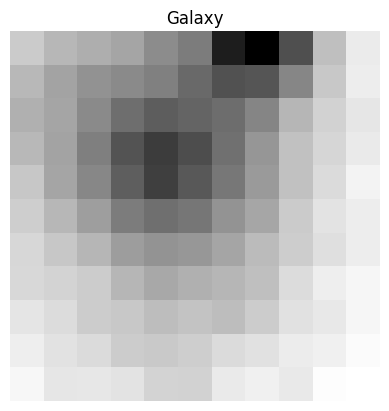

In [37]:
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs[:,:,0].T,cmap=cm.gray, interpolation='nearest')

In [42]:
#finding star and galaxies for display
fs=df['class'][df['class']=='STAR']
print(fs)
fq=df['class'][df['class']=='QSO']
print(fq)

15
25      QSO
41      QSO
45      QSO
63      QSO
64      QSO
       ... 
5191    QSO
5242    QSO
5246    QSO
5253    QSO
5288    QSO
Name: class, Length: 355, dtype: object


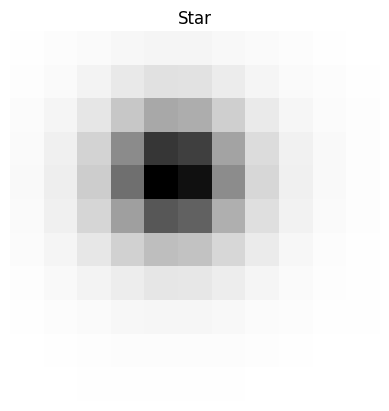

In [43]:
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs[:,:,fs.index[0]].T,cmap=cm.gray, interpolation='nearest')

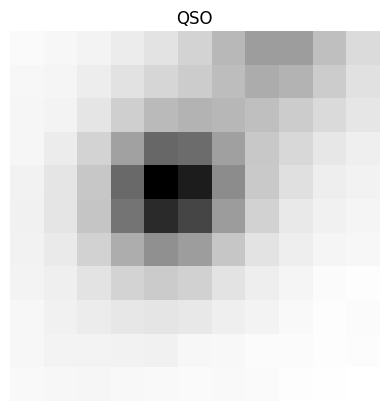

In [44]:
plt.axis('off')
plt.title("QSO")
plt.imshow(1-cut_outs[:,:,fq.index[0]].T,cmap=cm.gray, interpolation='nearest')

As it should be the galaxy is less concentrated than the star and the QSO. It is also visisble that the object are not fully isolated as often the case for images. 

I now drop the objects for which no image could have been found. I also add a forth dimension to the iamge array as needed by pytorch. I could add other colors, but for now I just use one color. The color I use combines the three color with the highest signal to noise to a single. That is useful in astronomy because astronomical images are noisy. 

Because of the noise to I not rescale the cut out images, since rescaling makes that noise is level is very different between different images, while it should be rather similar in this data set.    

In [45]:
#new data frame omitting the object where no image could be found 
df2=df[df.off_image==False]
#new image array, to which also a 4 dimension of zero size is added
cut_outs2=np.zeros((2*delta+1,2*delta+1,1,df2.shape[0]))
counter=0
for i in range(df.shape[0]):
    if df.off_image.iloc[i]==False:
        #adding the cut outs not of image
        cut_outs2[:,:,0,counter]=cut_outs[:,:,i]
        counter+=1
#Now I add the iamge value to the data frame, that can be used for all connected percitron networks 
x=0
for i in range(cut_outs2.shape[0]):
    for j in range(cut_outs2.shape[1]):
        df2[x]=cut_outs2[i,j,0,:]
        x+=1

/tmp/ipykernel_9508/2833182752.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_9508/2833182752.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_9508/2833182752.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Printing the head as test as often. 

In [46]:
print(df2.head())

   index                objid         ra       dec         u         g  \
0   2168  1237660239776908025  50.312948 -0.767717  21.92582  21.18044   
1   1286  1237663237128520044  50.432160 -1.103514  21.96684  20.35859   
2   1287  1237663237128520058  50.439437 -1.164617  22.09616  20.93119   
3    592  1237663237128388950  50.162303 -1.235258  22.20764  19.81604   
4    593  1237663237128388967  50.174576 -1.245299  22.56767  20.52426   

          r         i         z   run  ...        111        112        113  \
0  19.97416  19.64367  19.27409  3438  ...   6.554533   7.593651   7.016401   
1  19.48765  19.06683  18.82782  4136  ...   5.149033   5.307359   6.223897   
2  19.48183  18.93008  18.48824  4136  ...  11.629539  13.926988  10.528815   
3  18.69533  18.23049  17.89898  4136  ...   6.260189   7.919204  12.064778   
4  19.25002  18.78460  18.39242  4136  ...   2.556708   3.418560   5.017884   

         114        115        116        117        118        119        120  

Now the data is mostly preparred besides some libraries specifices. 

Start

In [28]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


First a multi layer percitron is tried for comparison. 

In [29]:
#transpose to #input format (Batch, Number Channels, height, width)
#is correct
#cut_outs2=np.transpose(cut_outs2,axes=[])
print(cut_outs2.T.shape,df2.shape)

(5259, 1, 11, 11) (5259, 146)


In [30]:
print(df2.columns[0:30])
print(df2.loc[:,0:120])
feature_train,feature_test,target_train, target_test,image_train,image_test= train_test_split(df2.loc[:,0:120],df2.loc[:,"galaxy"],cut_outs2.T,train_size=0.70, shuffle=True, random_state=1)
print(feature_train)

Index([    'index',     'objid',        'ra',       'dec',         'u',
               'g',         'r',         'i',         'z',       'run',
           'rerun',    'camcol',     'field', 'specobjid',     'class',
        'subclass',  'redshift',     'plate',       'mjd',   'fiberid',
          'galaxy',     'image',   'pixel_x',   'pixel_y', 'off_image',
                 0,           1,           2,           3,           4],
      dtype='object')
            0          1          2          3          4          5    \
0     11.617592  14.461045  15.607525  14.324944  12.140285  11.171863   
1     16.081114  16.799738  18.055048  15.552929  12.734963  10.322695   
2      4.226120   5.485828   8.985552  13.390948  15.201861  17.829788   
3     20.466120  28.390841  36.041962  42.825455  42.343952  37.694294   
4     11.149448  21.390976  34.866329  43.930313  37.140423  24.929573   
...         ...        ...        ...        ...        ...        ...   
5290  15.185962  17.562304 

In [31]:
print(image_test.shape,image_test.dtype,image_train.shape)

(1578, 1, 11, 11) float64 (3681, 1, 11, 11)


In [32]:
 
feature_train, target_train = np.array(feature_train), np.array(target_train)
feature_test, target_test = np.array(feature_test), np.array(target_test)
print(type(target_train),type(image_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [58]:
class ClassificationDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [59]:
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
print(max(torch.from_numpy(target_train).float()))
print(min(torch.from_numpy(target_train).float()))
print(max(torch.from_numpy(target_test).float()))
print(min(torch.from_numpy(target_test).float()))
print(type(torch.from_numpy(image_test).float()))
print(type(test_im_dataset))


tensor(1.)
tensor(0.)
tensor(1.)
tensor(0.)
<class 'torch.Tensor'>
<class '__main__.ClassificationDataset'>


In [193]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = 121

In [194]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [195]:
#now 3 layers 
#two options only 
class BinaryClassification3(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification3, self).__init__()
        self.fc1 = nn.Linear(num_features, 60)
        self.fc2 = nn.Linear(60, 20)  
        self.fc3 = nn.Linear(20, 8)        
        self.fc4 = nn.Linear(8, 1)   
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return (x)

In [196]:
model =BinaryClassification3(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification3(
  (fc1): Linear(in_features=121, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)


In [197]:
loss_stats = {
    'train': [], 'test': []
}


In [198]:

print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        test_epoch_loss = 0
        
        model.eval()
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            y_test_pred = model(X_test_batch)
                        
            test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
            test_epoch_loss += test_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.36753 | Test Loss: 0.29220
Epoch 002: | Train Loss: 0.36066 | Test Loss: 0.35051
Epoch 003: | Train Loss: 0.35731 | Test Loss: 0.27214
Epoch 004: | Train Loss: 0.31878 | Test Loss: 0.28682
Epoch 005: | Train Loss: 0.32973 | Test Loss: 0.28242
Epoch 006: | Train Loss: 0.35610 | Test Loss: 0.26965
Epoch 007: | Train Loss: 0.33331 | Test Loss: 0.22342
Epoch 008: | Train Loss: 0.32558 | Test Loss: 0.13529
Epoch 009: | Train Loss: 0.32719 | Test Loss: 0.14530
Epoch 010: | Train Loss: 0.30459 | Test Loss: 0.13333
Epoch 011: | Train Loss: 0.31495 | Test Loss: 0.73923
Epoch 012: | Train Loss: 0.40836 | Test Loss: 0.26044
Epoch 013: | Train Loss: 0.33434 | Test Loss: 0.13852
Epoch 014: | Train Loss: 0.30193 | Test Loss: 0.13946
Epoch 015: | Train Loss: 0.29953 | Test Loss: 0.13765
Epoch 016: | Train Loss: 0.27606 | Test Loss: 0.14584
Epoch 017: | Train Loss: 0.29520 | Test Loss: 0.20357
Epoch 018: | Train Loss: 0.28973 | Test Loss: 0.19979
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.12001 | Test Loss: 0.25378
Epoch 154: | Train Loss: 0.10419 | Test Loss: 0.33135
Epoch 155: | Train Loss: 0.10357 | Test Loss: 0.26889
Epoch 156: | Train Loss: 0.12631 | Test Loss: 0.27148
Epoch 157: | Train Loss: 0.17401 | Test Loss: 0.26121
Epoch 158: | Train Loss: 0.11911 | Test Loss: 0.25366
Epoch 159: | Train Loss: 0.10216 | Test Loss: 0.27195
Epoch 160: | Train Loss: 0.11563 | Test Loss: 0.25849
Epoch 161: | Train Loss: 0.10354 | Test Loss: 0.32576
Epoch 162: | Train Loss: 0.10581 | Test Loss: 0.27456
Epoch 163: | Train Loss: 0.10791 | Test Loss: 0.26661
Epoch 164: | Train Loss: 0.10342 | Test Loss: 0.26215
Epoch 165: | Train Loss: 0.10835 | Test Loss: 0.26971
Epoch 166: | Train Loss: 0.11037 | Test Loss: 0.34259
Epoch 167: | Train Loss: 0.10301 | Test Loss: 0.28652
Epoch 168: | Train Loss: 0.10192 | Test Loss: 0.29571
Epoch 169: | Train Loss: 0.09806 | Test Loss: 0.31835
Epoch 170: | Train Loss: 0.10684 | Test Loss: 0.31970
Epoch 171: | Train Loss: 0.1

In [199]:
def pred_torch(model,data):
    y_pred_list_c = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list_c.append(y_test_pred.cpu().numpy())
    y_pred_list_c = [a.squeeze().tolist() for a in y_pred_list_c]
    return y_pred_list_c  

In [202]:
m_test=pred_torch(model,test_loader)
m_train=pred_torch(model,train_loader_pred)
print(len(m_test))

1578


Now there is clear overfitting. 

Text(0, 0.5, 'BCE loss')

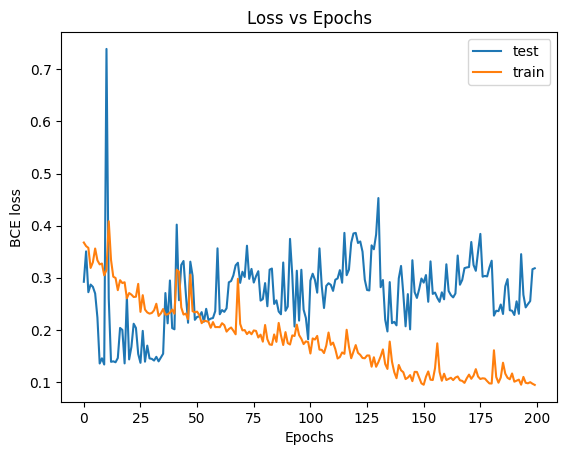

In [203]:

plt.plot(loss_stats['test'],label='test')
plt.plot(loss_stats['train'],label='train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

Needs regularization, but now i am building a first convolutional network also. 

In [329]:
#for conv 2d 
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS= 20
keep_prob=1
#seems not needed
#NUM_FEATURES = 121

In [330]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)

In [331]:
# Implementation of CNN/ConvNet Model  image 28 *28 size not changed  
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        # Conv -> (?, 28, 28, 32)
        # Pool -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        # Conv      ->(?, 14, 14, 64)
        # Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 62, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        # Conv ->(?, 7, 7, 128)
        # Pool ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [332]:
class CNNBinary3(torch.nn.Module):
    #no padding because image does not really end there
    def __init__(self):
        super(CNNBinary3, self).__init__()
        # L1 ImgIn shape=(?, 11, 11, 1)
        # Conv -> (?, 9, 9, 12)
        # Pool -> (?, 4, 4, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 4, 4, 32)
        # Conv      ->(?, 2, 2, 32)
        # Pool      ->(?, 1, 1, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 FC 1x1x32 inputs -> 16 outputs
        self.fc1 = torch.nn.Linear(1 * 1 * 32, 64, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 Final FC 64 inputs -> 1 output
        self.fc2 = torch.nn.Linear(64, 1, bias=True) #
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = torch.sigmoid(self.fc2(out))
        return out
#channel output size is s=

In [333]:
#size checking with samll example
# pool of square window of size=3, stride=2
m = nn.MaxPool2d(3, stride=2)
# pool of non-square window
m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(20, 16, 50, 32)
output = m(input)
print(input.shape)
print(output.shape)
#standard pool
m = nn.MaxPool2d((2, 2), stride=(2, 2))
#standard drops but can be changed, can also use pooling and co get better number 
input = torch.randn(20, 16, 9, 9)
output = m(input)
print(input.shape)
print(output.shape)
#input format (Batch, Number Channels, height, width)
b=torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
input2 = torch.randn(1, 16, 4, 4)
output2=b(input2)
print(input2.shape)
print(output2.shape)
output3 = m(output2)
print(output3.shape)

torch.Size([20, 16, 50, 32])
torch.Size([20, 16, 24, 31])
torch.Size([20, 16, 9, 9])
torch.Size([20, 16, 4, 4])
torch.Size([1, 16, 4, 4])
torch.Size([1, 32, 2, 2])
torch.Size([1, 32, 1, 1])


In [334]:
keep_prob1=1
model2 =CNNBinary3()
model2.to(device)
print(model2)
criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/tmp/ipykernel_7020/3556160450.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


In [335]:
def torch_fit(model,train_loader,test_loader,epochs,batch_size,learning_rate,loss_stats):
    learning_rate = learning_rate
    criterion = torch.nn.BCELoss()    # Softmax is internally computed.
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    #l2 regularization is added in optimizer as weight_decay=1e-5 or nsimilar 
    print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
        
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer.step()
        
            train_epoch_loss += train_loss.item()
        
        
        # VALIDATION    
        with torch.no_grad():
        
            test_epoch_loss = 0
        
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
                y_test_pred = model(X_test_batch)
                        
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
                test_epoch_loss += test_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')    

In [336]:
loss_stats_test = {
    'train': [], 'test': []
}
torch_fit(model2,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.61759 | Test Loss: 0.66811
Epoch 002: | Train Loss: 0.69020 | Test Loss: 0.39590
Epoch 003: | Train Loss: 0.92053 | Test Loss: 0.42858
Epoch 004: | Train Loss: 0.73692 | Test Loss: 0.36285
Epoch 005: | Train Loss: 0.60043 | Test Loss: 0.34198
Epoch 006: | Train Loss: 0.60547 | Test Loss: 0.34440
Epoch 007: | Train Loss: 0.46243 | Test Loss: 0.36811
Epoch 008: | Train Loss: 0.43406 | Test Loss: 0.31781
Epoch 009: | Train Loss: 0.48565 | Test Loss: 0.39902
Epoch 010: | Train Loss: 0.75563 | Test Loss: 0.43993
Epoch 011: | Train Loss: 0.48196 | Test Loss: 0.19882
Epoch 012: | Train Loss: 0.34558 | Test Loss: 0.19950
Epoch 013: | Train Loss: 0.33317 | Test Loss: 0.25961
Epoch 014: | Train Loss: 0.26291 | Test Loss: 0.25535
Epoch 015: | Train Loss: 0.26102 | Test Loss: 0.19430
Epoch 016: | Train Loss: 0.26413 | Test Loss: 0.25750
Epoch 017: | Train Loss: 0.30448 | Test Loss: 0.19549
Epoch 018: | Train Loss: 0.26092 | Test Loss: 0.19205
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.15603 | Test Loss: 0.14423
Epoch 154: | Train Loss: 0.13881 | Test Loss: 0.11224
Epoch 155: | Train Loss: 0.16297 | Test Loss: 0.13763
Epoch 156: | Train Loss: 0.15260 | Test Loss: 0.12436
Epoch 157: | Train Loss: 0.15124 | Test Loss: 0.11375
Epoch 158: | Train Loss: 0.15805 | Test Loss: 0.11966
Epoch 159: | Train Loss: 0.14499 | Test Loss: 0.18396
Epoch 160: | Train Loss: 0.16257 | Test Loss: 0.12424
Epoch 161: | Train Loss: 0.16807 | Test Loss: 0.12917
Epoch 162: | Train Loss: 0.15102 | Test Loss: 0.11614
Epoch 163: | Train Loss: 0.15803 | Test Loss: 0.11419
Epoch 164: | Train Loss: 0.15937 | Test Loss: 0.10997
Epoch 165: | Train Loss: 0.15585 | Test Loss: 0.11582
Epoch 166: | Train Loss: 0.14399 | Test Loss: 0.11756
Epoch 167: | Train Loss: 0.15747 | Test Loss: 0.11840
Epoch 168: | Train Loss: 0.15206 | Test Loss: 0.14044
Epoch 169: | Train Loss: 0.16223 | Test Loss: 0.12227
Epoch 170: | Train Loss: 0.15332 | Test Loss: 0.11665
Epoch 171: | Train Loss: 0.1

Text(0, 0.5, 'BCE loss')

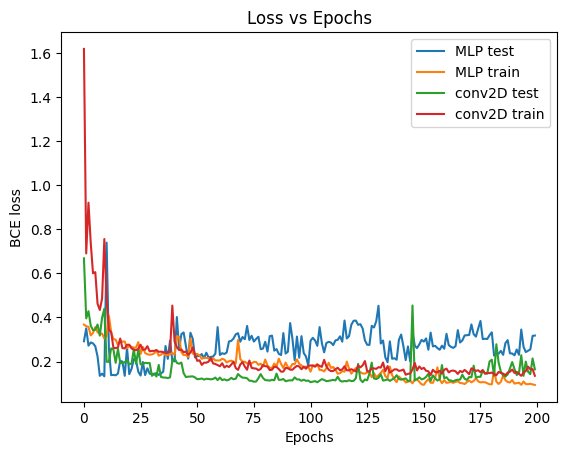

In [337]:
plt.plot(loss_stats['test'],label='MLP test')
plt.plot(loss_stats['train'],label='MLP train')
plt.plot(loss_stats_test['test'],label='conv2D test')
plt.plot(loss_stats_test['train'],label='conv2D train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

Convolutional looks better, less overfitting, but it a;sp not look perfect and the final loss is not really good. Could be not enough epochs for train. There are wiggles in test seem like that there is overfitting also there. Is there is o0verfitting there. 

In [338]:
#xgb for comparison 
xc1=XGBClassifier(max_depth=6,reg_alpha=0.01).fit(feature_train,target_train)

In [339]:
train_pred=xc1.predict(feature_train)
test_pred=xc1.predict(feature_test)

In [340]:
print(train_pred)

[1 1 0 ... 1 0 1]


In [341]:
conf_train = confusion_matrix(target_train, train_pred)
conf_test = confusion_matrix(target_test, test_pred)

In [342]:
print(conf_train)
print(conf_test)

[[1468    0]
 [   0 2213]]
[[575  34]
 [ 35 934]]


Does not look so bad. 

In [343]:
lc1=LogisticRegression(max_iter=3000).fit(feature_train,target_train)

In [344]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)

In [345]:
l_conf_train = confusion_matrix(target_train, l_train_pred)
l_conf_test = confusion_matrix(target_test, l_test_pred)

In [346]:
#2000 in train 91 56,  test 65 45  not converged warning
#now converged same fraction 
print(l_conf_train)
print(l_conf_test)

[[1377   91]
 [  56 2157]]
[[544  65]
 [ 45 924]]


Also not so bad. Howeever, both not perfect, thus possible that neural network is better. 

In [348]:
c_test=pred_torch(model2,test_im_loader)
c_train=pred_torch(model2,train_im_loader_pred)

In [349]:
def conf_for_torch(predict,target):
    #round prediction
    round_pred=np.round(np.array(predict))
    conf_matrix = confusion_matrix(target, round_pred)
    return conf_matrix

In [350]:
conf_test_m=conf_for_torch(m_test,target_test)
conf_train_m=conf_for_torch(m_train,target_train)
print("3 layer perceptron")
print("train")
print(conf_train_m)
print("test")
print(conf_test_m)

3 layer perceptron
train
[[1416   52]
 [  18 2195]]
test
[[575  34]
 [ 25 944]]


Percitron seems better than xgboost. Some problems with conv2d now, to be improved.

In [352]:
conf_test_c=conf_for_torch(c_test,target_test)
conf_train_c=conf_for_torch(c_train,target_train)
print("2 conv2D layers conv2D one other")
print("train")
print(conf_train_c)
print("test")
print(conf_test_c)

2 conv2D layers conv2D one other
train
[[1420   48]
 [  42 2171]]
test
[[584  25]
 [ 32 937]]


Both look similar good. Next calculating usual metrics for the four algorithms in their basic setups. 